In [342]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import h5py
import xarray as xr

#this sets the size of the plot to something useful
plt.rcParams["figure.figsize"] = (20,14)

# Lab 4: Working with 'real' data

In [310]:
hf = h5py.File('gammaray_lab4.h5','r')

In [311]:
data = np.array(hf.get('data'))

In [312]:
data[:,0] #time (gps seconds), solar phase (deg), earth longitude (deg), gamma-ray count

array([9.40680016e+08, 3.15000000e+02, 4.50000000e+01, 1.00000000e+01])

In [313]:
hf.close()

### Problem 1:
In this problem we are looking at the data from a gamma-ray satellite orbiting in low Earth orbit. It takes a reading of the number of particles detected every 100 milliseconds, and is in an approximately 90 minute orbit. While it is looking for gamma-ray bursts, virtually all of the particles detected are background cosmic rays.

##### 1) Explore your data by making a few plots and give a high level description of the data features you see. Do you see signal contamination in your data? How do you plan to build a background pdf()?

Data is a table with four columns: Time, Solar Phase, Longitude, and Gamma Ray Count.

In [314]:
step = 1
t = data[0][::step] #Reducing the number of data points for the sake of runtime efficiency.
phase = data[1][::step]
longitude = data[2][::step]
y = data[3][::step]

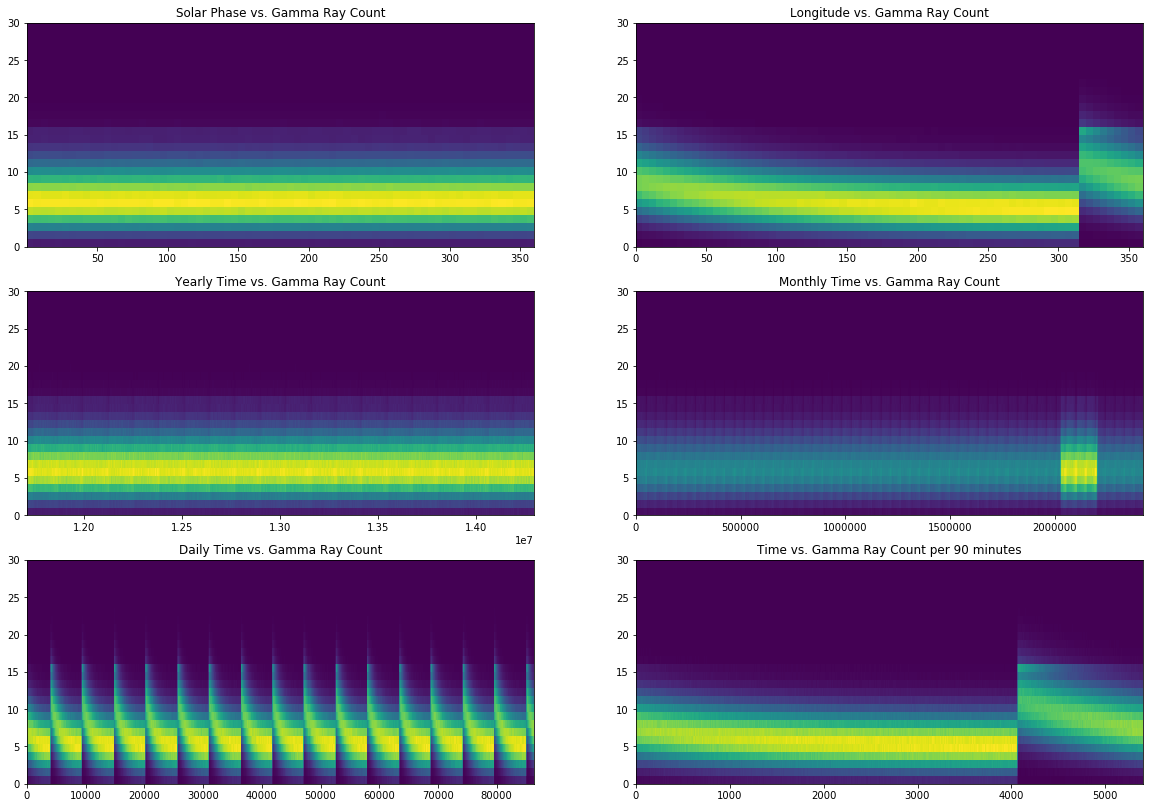

In [315]:
fig, ((plt1,plt2),(plt3,plt4),(plt5,plt6)) = plt.subplots(3,2)
plt1.hist2d(phase,y, bins = [72,28])
plt2.hist2d(longitude,y, bins = [72,28])
plt3.hist2d(t%29030400,y, bins = [500,28])
plt4.hist2d(t%2419200,y, bins = [500,28])
plt5.hist2d(t%86400,y, bins = [500,28])
plt6.hist2d(t%5400,y, bins = [500,28])

plt1.title.set_text('Solar Phase vs. Gamma Ray Count')
plt2.title.set_text('Longitude vs. Gamma Ray Count')
plt3.title.set_text('Yearly Time vs. Gamma Ray Count')
plt4.title.set_text('Monthly Time vs. Gamma Ray Count')
plt5.title.set_text('Daily Time vs. Gamma Ray Count')
plt6.title.set_text('Time vs. Gamma Ray Count per 90 minutes')

As we can see here, the number of gamma rays detected remains mostly constant with respect to solar phase. Also, the number of gamma rays seems to be independent of time on the large scale (ie. in any two 1 year periods, we expect to detect the same number of gamma rays). However, when we look at time on a smaller scale, examining the rate of detection over the course of one day, a clear pattern emerges showing 16 periods per day. Indeed, a single 90 minute period looks exactly the same as the longitude vs. detection plot. It seems to me that this tells us that there exists some signal contamination wherein the satelite detects an unusually high number of gamma rays compared to the background radiation every 90 minutes.

These plots also show another curious phenomenon, in which it seems that every month there is a small period of time during which an unusually high number of gamma rays are detected. However, this period does not seem to appear to be significantly noticeable on anything but a monthly scale, so we will ignore it throughout this lab.

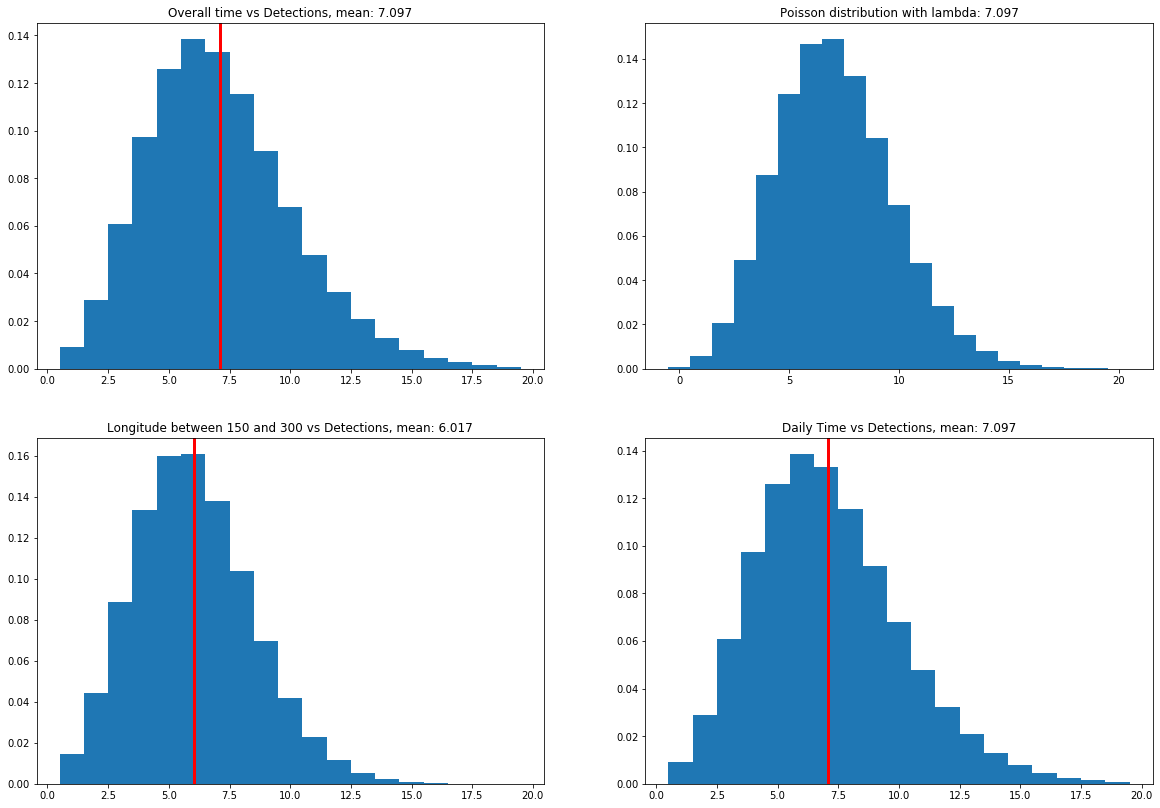

In [316]:
fig, ((plt1,plt2),(plt3,plt4)) = plt.subplots(2,2)
lsection = np.logical_and(longitude>150, longitude<300)
tsection = np.logical_and((t%86400)>0, (t%86400)<86401)
x = range(0,21)
mean = np.mean(y)
lmean = np.mean(y[lsection])
tmean = np.mean(y[tsection])

plt1.hist(y, bins=np.arange(0.5,20,1),density=True)
plt2.bar(x, stats.poisson.pmf(x,mean),width=1)
plt3.hist(y[lsection],bins=np.arange(0.5,20,1), density=True)
plt4.hist(y[tsection],bins=np.arange(0.5,20,1), density=True)

plt1.axvline(mean,linewidth=3,color='red')
plt3.axvline(lmean, linewidth=3, color = 'red')
plt4.axvline(tmean, linewidth=3, color = 'red')
plt1.title.set_text('Overall time vs Detections, mean: ' +str(np.round(mean,3)))
plt2.title.set_text('Poisson distribution with lambda: '+str(np.round(mean,3)))
plt3.title.set_text('Longitude between 150 and 300 vs Detections, mean: '+str(np.round(lmean,3)))
plt4.title.set_text('Daily Time vs Detections, mean: '+str(np.round(tmean,3)))

Here we examine the background distribution, and find that while the background distribution is a Poisson distribution on both small and large scales, the mean value of the poisson varies throughout the day based on where the satelite is in relation to the earth.

##### 2) The background is not consistent across the dataset. Find and describe as accurately as you can how the background changes.

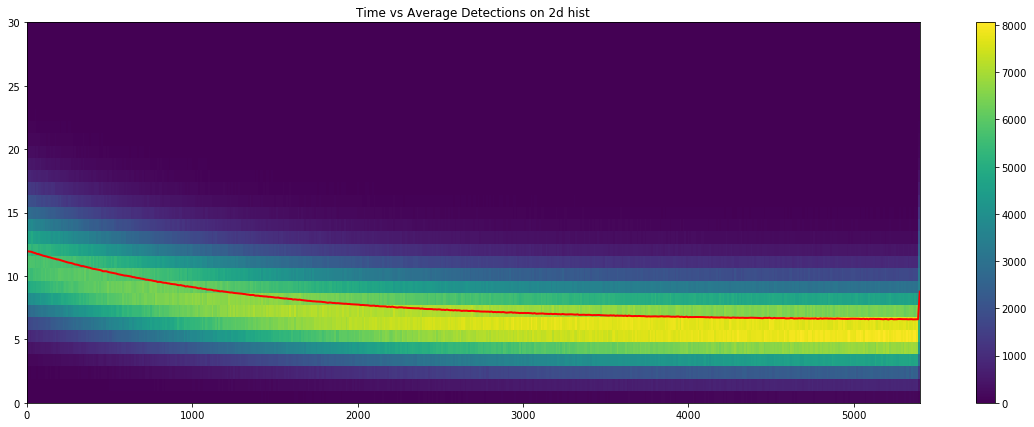

In [328]:
plt.rcParams["figure.figsize"] = (20,7)
dist = plt.hist2d((t+1330)%5400,y, bins=[540,31]) #In order to see if there is a clearer relation, we shift our window from 0-90 minutes to 22-112 minutes.
mean = np.zeros(540)

for i in range(0,540):
    mean[i] = sum(dist[2][1:]*dist[0][i,:]/sum(dist[0][i,:]))
    

plt.plot(dist[1][1:], mean, linewidth=2, color = 'red')
plt.title('Time vs Average Detections on 2d hist')
plt.colorbar()
plt.show()

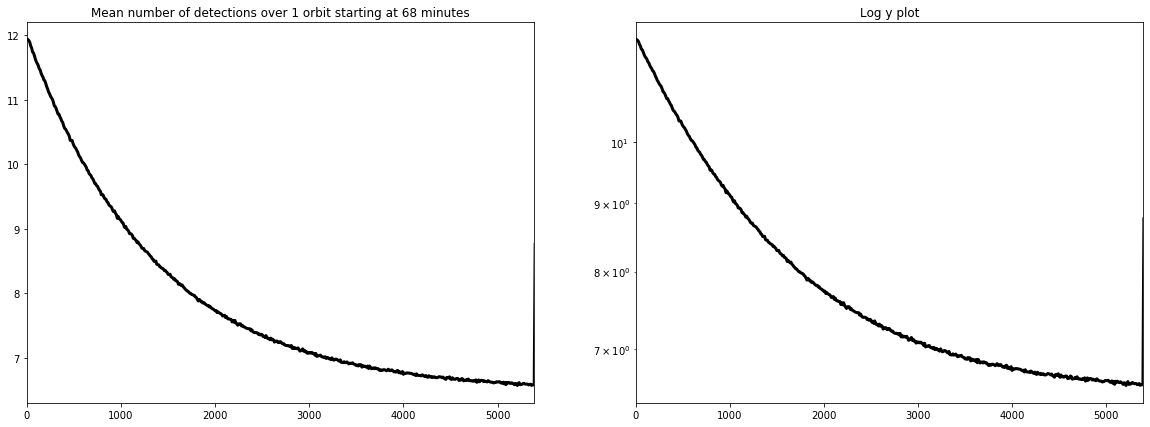

In [329]:
fig, (plt1,plt2) = plt.subplots(1,2)

plt1.plot(dist[1][1:], mean, linewidth=3,color='black')
plt1.set_xlim([0,5390])
plt1.title.set_text('Mean number of detections over 1 orbit starting at 68 minutes')

plt2.plot(dist[1][1:], mean, linewidth=3,color='black')
plt2.set_xlim([0,5390])
plt2.set_yscale('log')
plt2.title.set_text('Log y plot')

plt.show()

As we noted in 1-1, the signal seems to depend on the longitude of the observation device. Above, we plot the average number of observations detected by the satelite per second in ten second increments. The mean appears to decay exponentially from just under 12 to the background value of 6.015. However, because the log(y) scale is non-linear, it seems there is no exponential relationship.

##### 3) Create a model for the background that includes time dependence, and explicitly compare your model to the data. How good is your model of the background?

The underlying distribution is a Poisson distribution, as gamma ray detections are discrete events. Therefore we use a Poisson distribution to model our data over the course of a 90 minute chunk of time (the time it takes for one orbit). Because there is no obvious equation relating time and the number of detections, we will instead look at many different timeframes to show that our model is accurate to the real data.

$$P_{k}(t) = \frac{\lambda(t)^ke^{-\lambda(t)}}{k!}$$

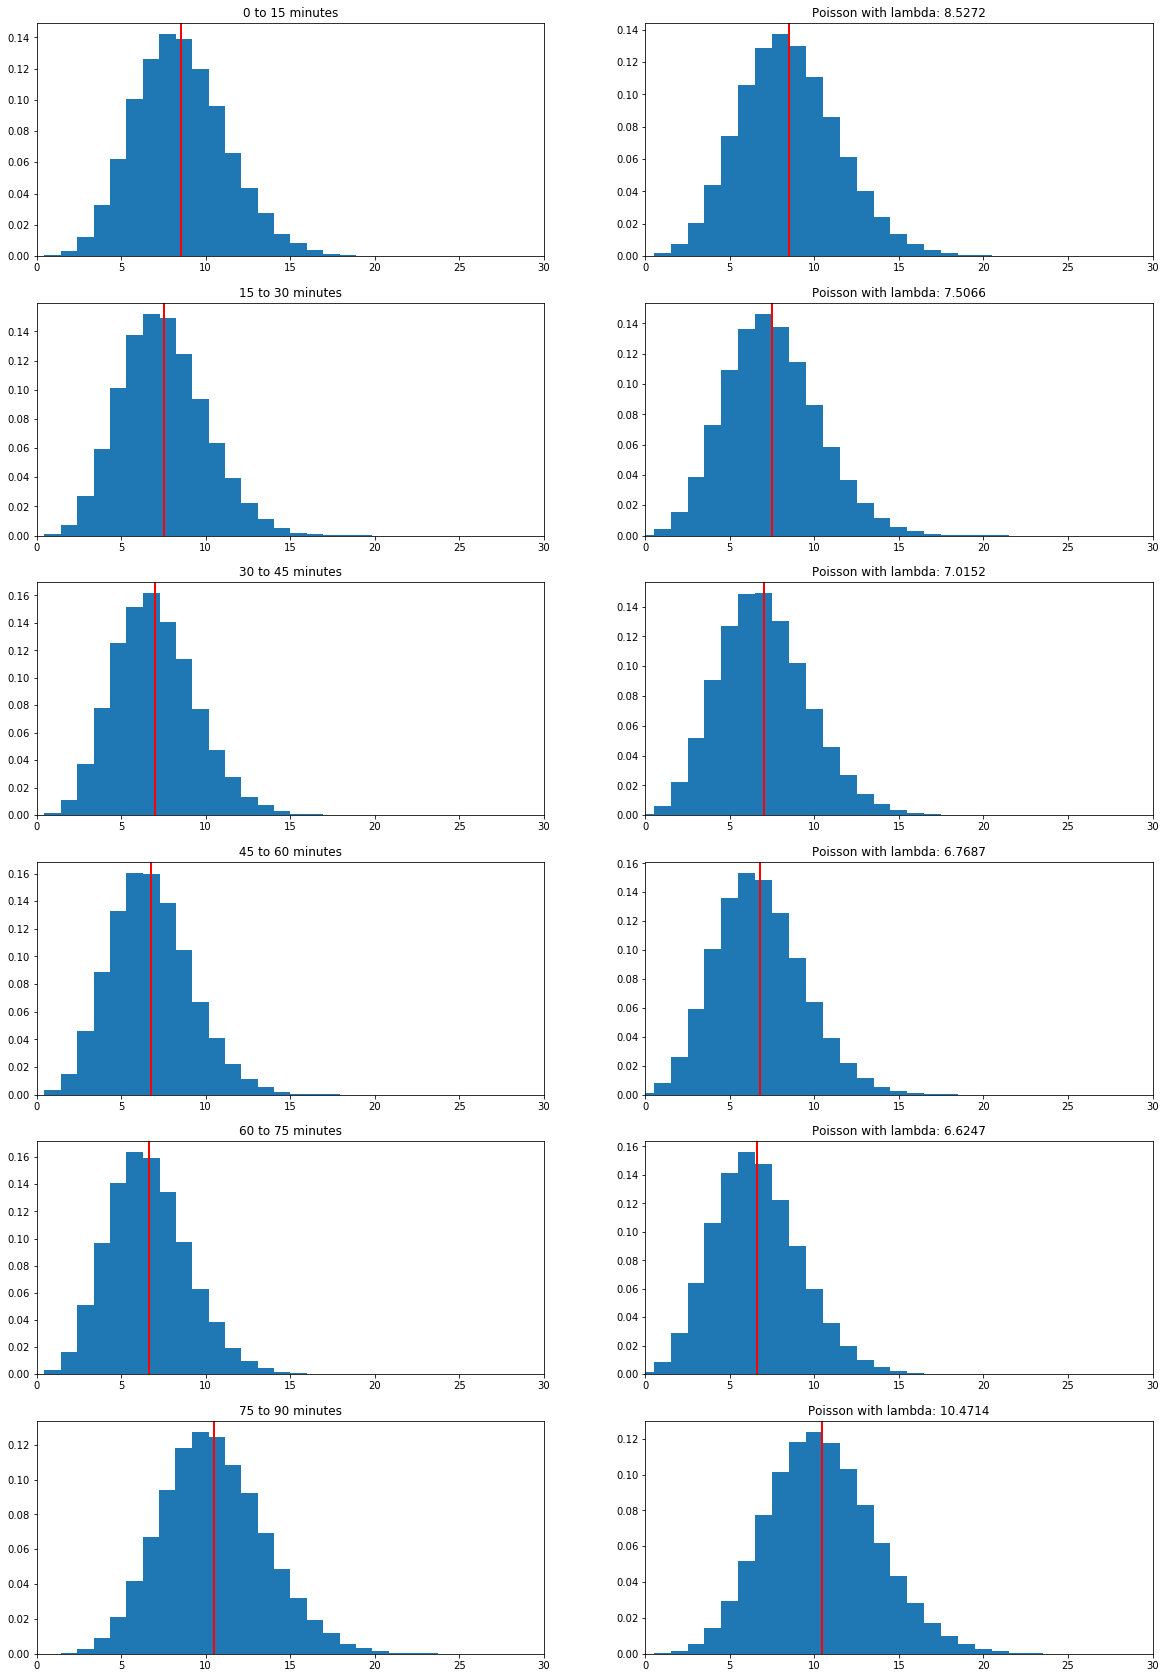

In [333]:
plt.rcParams["figure.figsize"] = (20,30)
dist = plt.hist2d((t)%5400,y, bins=[540,31]) #Shifting back our window so that t=0 corresponds to longitude = 0
mean = np.zeros(540)
x = range(0,540)
for i in range(0,540):
    mean[i] = sum(dist[2][1:]*dist[0][i,:]/sum(dist[0][i,:]))
plt.close()
fig, ((plt1,pois1),(plt2,pois2),(plt3,pois3),(plt4,pois4),(plt5,pois5),(plt6,pois6)) = plt.subplots(6,2)


#0-14, 15-29, 30-44, 45-59, 60-74, 75-89
plots = [plt1,plt2,plt3,plt4,plt5,plt6]
pois = [pois1,pois2,pois3,pois4,pois5,pois6]

for step in range(0,6):
    n = 90*step
    plots[step].bar(dist[2][1:],dist[0][n,:]/sum(dist[0][n,:]),width=1)
    plots[step].set_xlim([0,30])
    plots[step].axvline(mean[n],color='red',linewidth=2)
    plots[step].title.set_text(str(step*15) + ' to ' + str(step*15+15) + ' minutes' )
    
    pois[step].bar(x,stats.poisson.pmf(x,mean[n]),width=1)
    pois[step].set_xlim([0,30])
    pois[step].axvline(mean[n],color='red',linewidth=2)
    pois[step].title.set_text('Poisson with lambda: ' + str(np.round(mean[n],4)))
    

Each of these plots shows a smale slice from the 2d histogram comparing time and the number of detections (left) compared to the poisson distribution with a $\lambda$ equal to the average number of detections per slice (right). The plots are clearly quite similar in each case, but it is clear that the mean does change over time. The red line in each plot signifies the average number of detections per slice.

##### 4) Because the background varies, your discovery sensitivity threshold (how many particles you would need to see) also varies. What is the '5-sigma' threshold for a 100 millisecond GRB at different times?



In [337]:
prob_5sigma = stats.norm.cdf(5)
#stats.poisson.ppf(prob_5sigma,mean[0])
for time in range(0,6):
    print('Threshold for 5 sigma between ', str(time*15), ' and ', str(time*15+15), ' minutes after orbit begins is:',
          stats.poisson.ppf(prob_5sigma,mean[90*time]),'gamma rays in one 100 millisecond GRB')

Threshold for 5 sigma between  0  and  15  minutes after orbit begins is: 27.0 gamma rays in one 100 millisecond GRB
Threshold for 5 sigma between  15  and  30  minutes after orbit begins is: 25.0 gamma rays in one 100 millisecond GRB
Threshold for 5 sigma between  30  and  45  minutes after orbit begins is: 24.0 gamma rays in one 100 millisecond GRB
Threshold for 5 sigma between  45  and  60  minutes after orbit begins is: 23.0 gamma rays in one 100 millisecond GRB
Threshold for 5 sigma between  60  and  75  minutes after orbit begins is: 23.0 gamma rays in one 100 millisecond GRB
Threshold for 5 sigma between  75  and  90  minutes after orbit begins is: 30.0 gamma rays in one 100 millisecond GRB


##### Optional: while this is simulated data, it is based on a real effect seen by low Earth orbit satellites. Can you identify the cause of the variable background and propose a physical model?

One possibility is that this is caused by some kind of gamma ray source on the surface of the Earth which shoots gamma rays at the satelite when it is at 330 degrees longitude.

In reality, The signal contamination at 330 degrees longitude is due to the South Atlantic Anomaly, where Earth's inner Van Allen radiation belt comes closest to the Earth's surface. This anomaly is a result of the fact that Earth and the magnetic dipole of earth are not concentric, and the SAA is the near-Earth region where Earth's magnetic field is weakest relative to an idealized Earth-centered dipole field.

### Problem 2:

In this problem we examine a stack of simulated telescope images. Using these 10 images, we will look for the faintest stars in the images.

##### 1) Dowload the data from images.h5. This is a stack of 10 square images, each 200 pixels on a side.


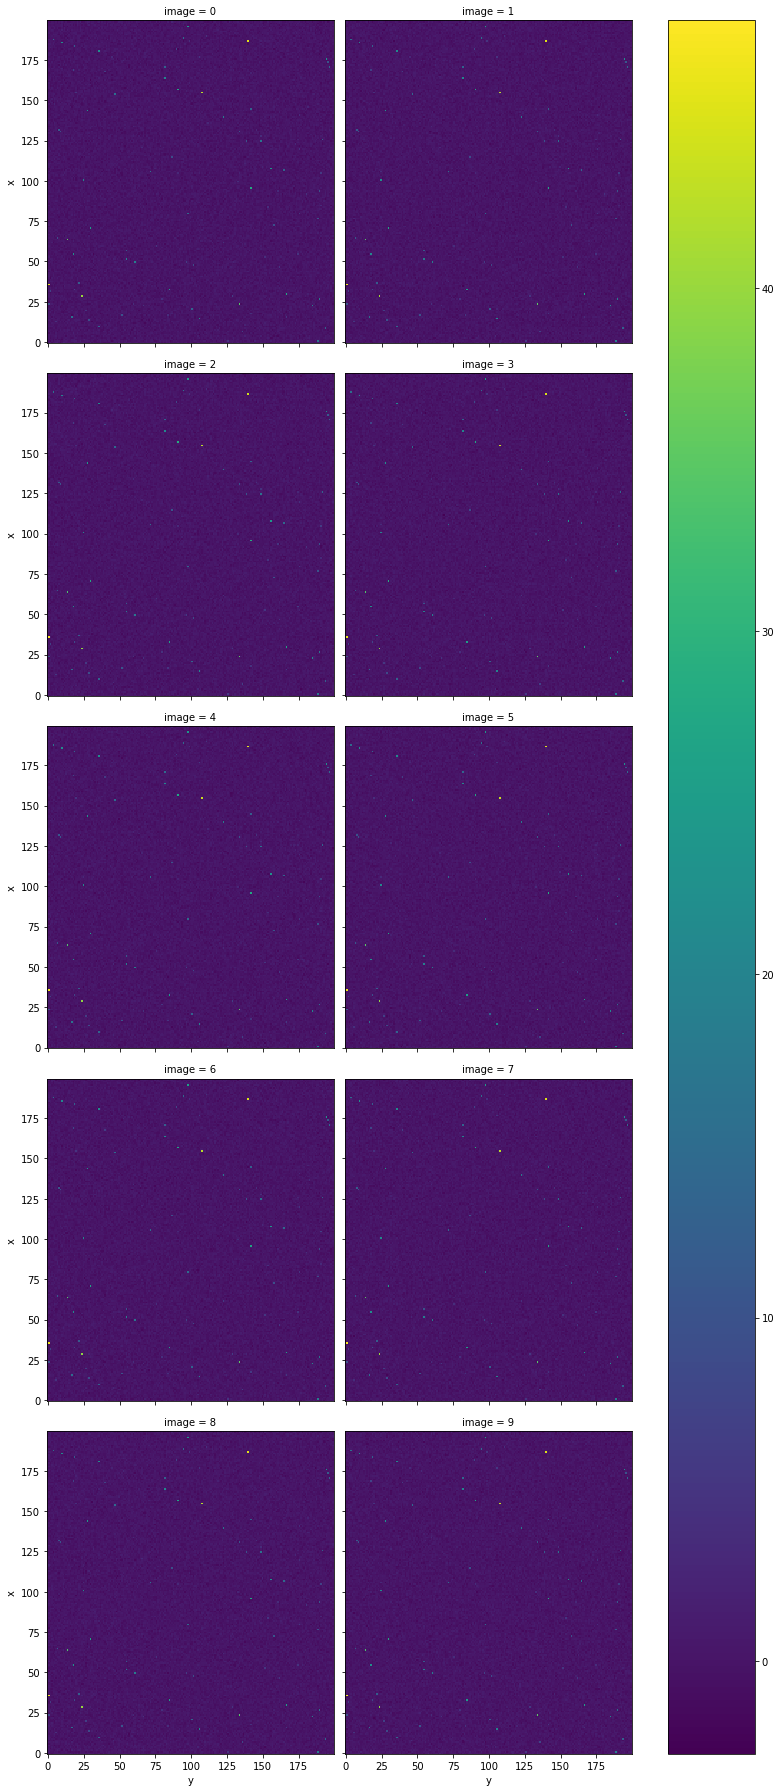

In [347]:
im = h5py.File('images.h5','r')
stack = xr.DataArray(im.get('imagestack')[:,:,:], coords=[np.arange(200), np.arange(200), np.arange(10)], dims=['x','y','image']).transpose('image','x','y')
stack.plot(center=False, col='image', col_wrap=2, size=5)
im.close()
plt.show()

##### 2) Explore the data. Is there signal contamination? Is the background time dependent? Is it consistent spatially? Develop a plan to calculate your background pdf().

At first glance, each of the 10 images seems the same and there seems to be no significant signal contamination. Because stars don't change in brightness over time, the background shouldn't be time dependant. To find the background pdf, we sum the pictures and then remove outliers at a sensitivity threshold, after which points past the trheshold may be considered faint stars instead of background noise.

##### 3) Using your background distribution, hunt for your signal (either faint stars, or a transient). Describe what you find.

First things first, we'll make a log scaled histogram of the images.

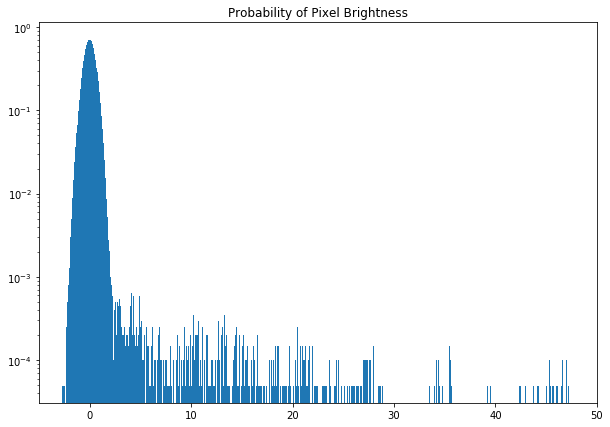

In [352]:
stack.plot.hist(bins=1000, density=True, size=7)
plt.title("Probability of Pixel Brightness")
plt.xlim([-5,50])
plt.yscale('log')
plt.show()

Now we use our techniques from Lab 2 to convolve and average this distribution.

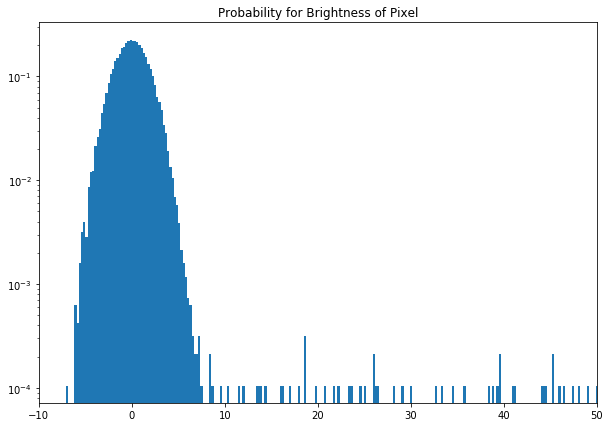

In [355]:
stacksum = sum(stack)
stacksum.plot.hist(bins=2000, density=True, size=7)
plt.title("Probability for Brightness of Pixel")
plt.xlim([-10,50])
plt.yscale('log')
plt.show()

Now we trim our data so we are only looking at the faintest stars and the background.

In [362]:
sstrim = stacksum.where(stacksum<10)
mean = sstrim.mean().values
std = sstrim.std().values
print(f"Mean: {mean:.3f}")
print(f"Standard Deviation: {std:.3f}")

Mean: -0.001
Standard Deviation: 1.778


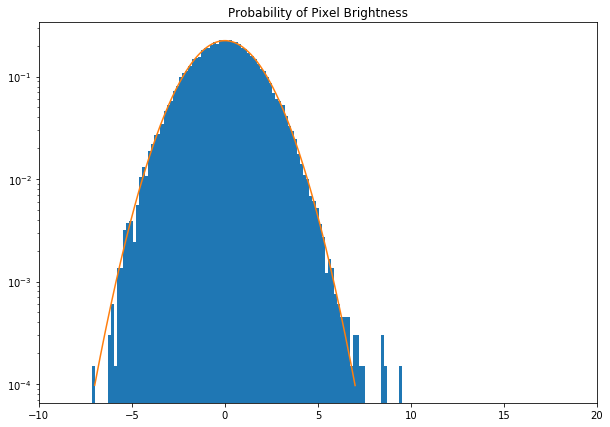

In [363]:
sstrim.plot.hist(bins=100,density=True,size=7)
x = np.linspace(-7,7,1000)
pdf = stats.norm.pdf(x,loc=mean,scale=std)
plt.plot(x,pdf)
plt.title("Probability of Pixel Brightness")
plt.xlim([-10,20])
plt.yscale('log')
plt.show()

Now that we have the background pdf of the sum of the pictures, we will determine a sensitivity threshold to choose how to define a faint star.

In [367]:
def dt(th):
    thprob = stats.norm.sf(th)
    signal = stats.norm.isf(thprob, loc=mean, scale=std)
    print(f"A pixel with intensity {signal:.2f} is a {th} sigma event")
    n = stacksum.where(stacksum > signal).count().values
    print(f"Over all the pictures, there are {n} pixels that are stars with {th} sigma certainty.")

dt(5)

A pixel with intensity 8.89 is a 5 sigma event
Over all the pictures, there are 125 pixels that are stars with 5 sigma certainty.


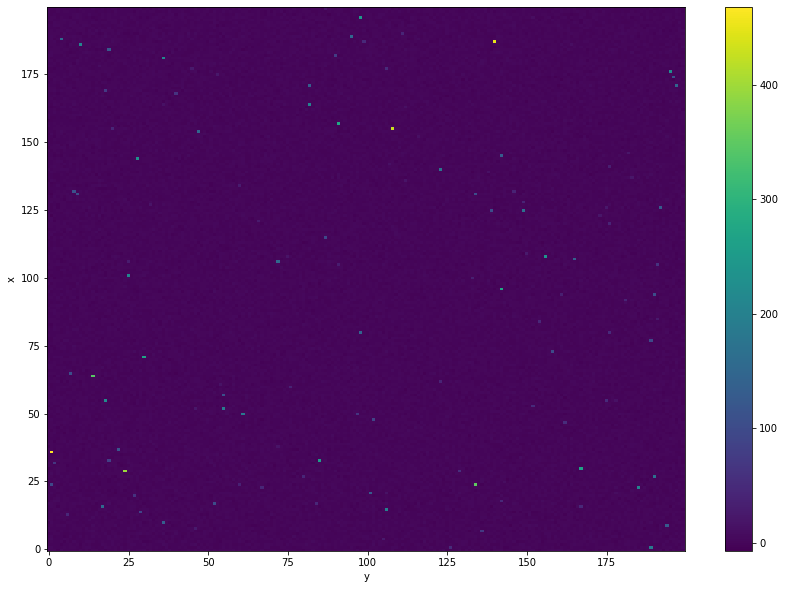

In [377]:
stack_sum.plot(center=False, col_wrap=2, size=10)
plt.show()

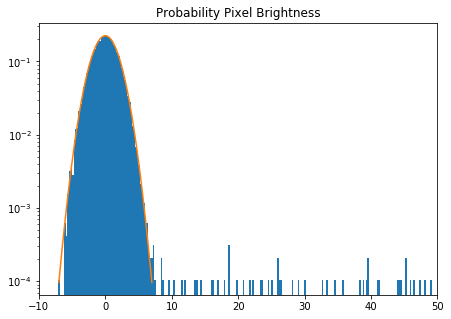

In [378]:
stacksum.plot.hist(bins=2000, density=True, size=5)
plt.plot(x, pdf)
plt.title("Probability Pixel Brightness")
plt.xlim([-10,50])
plt.yscale('log')
plt.show()

In [379]:
dt(10)

A pixel with intensity 17.78 is a 10 sigma event
Over all the pictures, there are 114 pixels that are stars with 10 sigma certainty.


The image above is a sum of all the images in the stack. Note how it brings the stars sharply into focus against the low intensity background. Below that, we have a log scaled histogram with all the outliers included and the pdf of the background plotted in orange. Every spike past ~x=9 is a star with 5 sigma certainty. If we choose a more discerning threshold of 10 sigma, we lose 11 stars - there are the faintest stars which we can be reasonably certain exist and are not noise.

##### 4) You and your lab partner had different pdf(), but were using the same data. Explore why this is.

My partner and I are looking for different events; it stands to reason that the tools we use will also be different. To search for the faintest stars, our pdf would be the sum over multiple trials, which helps identify persistent features but does nothing to find an event which only occurs a single time. By contrast, my partner would be looking for the difference between images and create a pdf for the average ambient noise created by taking this differnece, then use that to look for high significance outliers.